## Estimate melt fraction F, from trace element concenrations in n samples (assume F is the same for all samples).


Summary of estimated parameters
---------------------------------
Estimated melt fraction, F: 0.17 +/- 0.03

Observed C1: [ 1.   44.54  2.7   1.49] 
Predicted C1 [ 1.1   35.743  3.073  2.035]

Observed Zr/Nb ratio: 47.60 Model: 32.48

Observed Dy/Yb ratio: 0.55 Model: 0.66

     ['Nb', 'Zr', 'Yb', 'Dy']

C0 : [0.148 5.082 0.505 0.365]

P  : [0.012 0.095 0.326 0.301]

D  : [0.004 0.027 0.093 0.106]

Dx : [0.008 0.007 0.006 0.034]


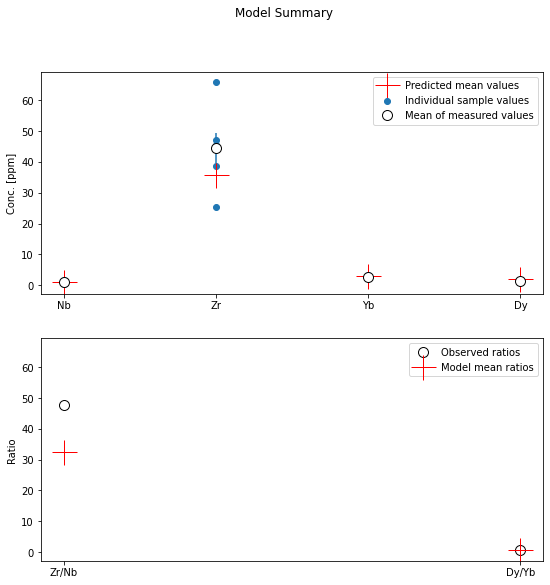

In [73]:
# -*- coding: utf-8 -*-

# Import required modules
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Set initial concentrations in mantle source, C0 values; Nb,Zr,Dy,Yb
#C0 = np.array([0.2462,6.087,0.543,0.382]) #enriched MOR
C0 = np.array([0.1485,5.082,0.505,0.365]) #normal MOR

#C0 = np.array([0.0864,4.267,0.471,0.348]) #depleted MOR

# Measured concentrations of trace elements in samples; Nb,Zr,Dy,Yb

data = {
        'Nb':[0.77,0.86,1.16,1.74,0.45],
        'Zr':[38.8,45.5,47.0,66.1,25.3],
        'Yb':[2.70,2.72,2.75,3.16,2.19],
        'Dy':[1.53,1.45,1.48,1.71,1.26],
       }
traces = list(data.keys())
n = len(data['Nb'])
ntraces = ['Nb']*n+['Zr']*n+['Yb']*n+['Dy']*n
concentrations = np.array(list(data.values()))

#print(ntraces)
#print(concentrations.flatten())

trace_data = pd.DataFrame(data=data)

# Mean concentrations
C1 = np.array([1.00,44.54,2.70,1.49])
sc1 = np.array([0.25,5.0,0.5,0.3])  #Add arbitrary (made up) stddev of measured values

# Mineral proportions in mantle source and melt modes
mntl_modes = np.array([0.58,0.27,0.12,0.03])
melt_modes = np.array([0.2,0.25,0.45,0.1])

#Distribution coefficients for minerals; ol,opx,cpx,sp
Kd = {
      'Nb':[0.00005,0.0015,0.0081,0.08],
      'Zr':[0.00068,0.004,0.195,0.06],
      'Yb':[0.0055,0.015,0.711,0.008],
      'Dy':[0.0366,0.032,0.633,0.0076]   
     }

# Calculate bulk distribution coeeficients for melt (do this elegantly, i.e. properly with loop or something sensible :-)
P_Nb = sum(Kd['Nb']*melt_modes)
P_Zr = sum(Kd['Zr']*melt_modes)
P_Yb = sum(Kd['Yb']*melt_modes)
P_Dy = sum(Kd['Dy']*melt_modes)

# Calculate bulk distribution coeeficients for solid
D_Nb = sum(Kd['Nb']*mntl_modes)
D_Zr = sum(Kd['Zr']*mntl_modes)
D_Yb = sum(Kd['Yb']*mntl_modes)
D_Dy = sum(Kd['Dy']*mntl_modes)

# Calculate fractional crystallisation D using FC modal values for ol and sp
Kdx = {
      'Nb':[0.00005,0.08],
      'Zr':[0.00068,0.06],
      'Yb':[0.0055,0.008],
      'Dy':[0.0366,0.0076]   
      }
xtl_modes = np.array([0.9,0.1])

Dx_Nb = sum(Kdx['Nb']*xtl_modes)
Dx_Zr = sum(Kdx['Zr']*xtl_modes)
Dx_Yb = sum(Kdx['Yb']*xtl_modes)
Dx_Dy = sum(Kdx['Dy']*xtl_modes)

# Store bulk distribution coefficients in numpy array for use
P = np.array([P_Nb,P_Zr,P_Yb,P_Dy])
D = np.array([D_Nb,D_Zr,D_Yb,D_Dy])
Dx = np.array([Dx_Nb,Dx_Zr,Dx_Yb,Dx_Dy])

# Package 1D arrays of C0,P and D to pass into the function to solve
Variables = np.array([C0,P,D,Dx])

# Define function for use with curve_fit()
def meltfc(Variables,F):
    X = 0.8 # Fraction of melt remaining after FC of ol+sp
    C0,P,D,Dx = Variables  #Unpack 1D arrays
    return ((C0/((F*(1-P))+D))*(X**(Dx-1)))

# Do curve fit stuff here with bounds
#-------------------------------------------------------------------

F0 = 0.5  #Initial guess for F
X0 = 0.7  #Initial guess for X

#initial_guess = ([0.5,0.8])
initial_guess = ([0.5])
# Set min-max bounds on parameter search for F
#param_bounds = ([0.001,0.79],[1.,0.81])
param_bounds = ([0.001],[1.])

# Run non-linear curve fit [popt is an array containing optimum fitted parameter values, pcov is the covariance matrix]
popt, pcov = curve_fit(meltfc, Variables, C1, sigma=sc1, p0=initial_guess, bounds=param_bounds, method='dogbox')

perr = np.sqrt(np.diag(pcov))


# Calculate observed and predicted ratios Zr/Nb and Dy/Yb
Nb = np.array(concentrations[0,:])
Zr = np.array(concentrations[1,:])
Yb = np.array(concentrations[2,:])
Dy = np.array(concentrations[3,:])

ZrNbr = Zr/Nb
DyYbr = Dy/Yb

ratios = ['Zr/Nb','Dy/Yb']
ratio_values = [np.mean(ZrNbr),np.mean(DyYbr)] # We use the mean values to plot/compare with model

C1_model = meltfc(Variables,*popt)
model_ZrNbr = C1_model[1]/C1_model[0]
model_DyYbr = C1_model[3]/C1_model[2]

model_ratios = [model_ZrNbr,model_DyYbr]

#print(ZrNbr, np.mean(ZrNbr))
#print(DyYbr, np.mean(DyYbr))

#print (ZrNbr, DyYbr)

# Write out results of interest...
print ('\nSummary of estimated parameters\n---------------------------------')
print (f'Estimated melt fraction, F: {popt[0]:.2f} +/- {perr[0]:.2f}')
#print (f'Estimated xtls fraction, X: {popt[1]:.2f} +/- {perr[1]:.2f}')

np.set_printoptions(precision=3,suppress=True)
print(f'\nObserved C1: {C1} \nPredicted C1 {meltfc(Variables,*popt)}')
print(f'\nObserved Zr/Nb ratio: {np.mean(ZrNbr):.2f} Model: {model_ZrNbr:.2f}')
print(f'\nObserved Dy/Yb ratio: {np.mean(DyYbr):.2f} Model: {model_DyYbr:.2f}')
print('\n    ',traces)
print('\nC0 :',C0);print('\nP  :',P);print('\nD  :',D);print('\nDx :',Dx)
    

# Draw plot (basically a simple x,y graph, uses matplotlib routines from pyplot)
#--------------------------------------------------------
style_data = {'marker':'o','markersize':10, 'markerfacecolor':'w', 'markeredgecolor':'k',
       'elinewidth':1.5,'linewidth':0}

fig, axs = plt.subplots(2, 1, figsize=(9, 9), sharey=True)

axs[0].set_ylabel('Conc. [ppm]')

# Observed mean values
axs[0].errorbar(traces, C1, yerr=sc1, label='Mean of measured values', **style_data)

# Observed individual sample values
axs[0].scatter(ntraces,concentrations.flatten(), label='Individual sample values')

# Model predictions
axs[0].plot(traces, meltfc(Variables,*popt),'+', markersize=25, markerfacecolor='w',
            markeredgecolor='r', label='Predicted mean values')

axs[0].legend()

# Plot ratios
axs[1].set_ylabel('Ratio')
axs[1].plot(ratios,ratio_values,'o',markersize=10, markerfacecolor='w',
            markeredgecolor='k',label='Observed ratios')
axs[1].plot(ratios, model_ratios,'+', markersize=25, markerfacecolor='w',
            markeredgecolor='r', label='Model mean ratios')
axs[1].legend()

fig.suptitle('Model Summary')

plt.show()
